<a href="https://colab.research.google.com/github/keerthana-narra/csat_score_prediction_dl/blob/main/CSAT_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Satisfaction Scores using Deep Learning**



##### **Project Type**    - Deep Learning

**Github link :** [Github](https://github.com/keerthana-narra/CSAT-score-prediction-DL)

**Project Documentation** : [Documentation](https://docs.google.com/document/d/1bBNIqykhKehADVZ0dzgzPOmfkhAEQOwm/edit?usp=drive_link&ouid=101693464124780926449&rtpof=true&sd=true)

**Presentation** : [Video link]

# **Problem Statement and Objective**


**Problem Overview**

This project focuses on predicting Customer Satisfaction (CSAT) scores using Deep Learning Artificial Neural Networks (ANN). In the context of e-commerce, understanding customer satisfaction through their interactions and feedback is crucial for enhancing service quality, customer retention, and overall business growth.


**Objective:**

 The goal of project is to leverage advanced neural network models, to forecast CSAT scores based on a myriad of interaction-related features, providing actionable insights for service improvement.

# ***Let's Begin !***

## ***1. Know Your Data***

Before we diving into the project, our initial step is to familiarize ourselves with the dataset. Let's load the data and take a look.

### Import Libraries

In [1]:
#!pip install -r requirements.txt

# Import Libraries
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from sklearn import preprocessing
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import uniform, randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Dataset Loading

In [2]:
# #Mount drive and Load data
# from google.colab import drive
# drive.mount('/content/drive')
#df=pd.read_csv('/content/drive/MyDrive/Almabetter/Masters/Specilization/Module4/Capstone/data/eCommerce_Customer_support_data.csv')

#Load the dataset
df = pd.read_csv('data/eCommerce_Customer_support_data.csv')

In [3]:
# Change column names to lowercase with underscores instead of spaces
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Peek into data 👀

In [4]:
#First 5 rows
df.head(2)

,unique_id,channel_name,category,sub-category,customer_remarks,order_id,order_date_time,issue_reported_at,issue_responded,survey_response_date,customer_city,product_category,item_price,connected_handling_time,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5


In [5]:
#Last 5 rows
df.tail(2)

,unique_id,channel_name,category,sub-category,customer_remarks,order_id,order_date_time,issue_reported_at,issue_responded,survey_response_date,customer_city,product_category,item_price,connected_handling_time,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score
85905,707528ee-6873-4192-bfa9-a491f1c08ab5,Inbound,Feedback,UnProfessional Behaviour,NaN,a031ec28-0c5e-450e-95b2-592342c40bc4,NaN,31/08/2023 19:59,31/08/2023 20:00,31-Aug-23,NaN,NaN,NaN,NaN,Daniel Martin,Olivia Suzuki,Olivia Tan,>90,Morning,4
85906,07c7a878-0d5a-42e0-97ef-de59abec0238,Inbound,Returns,Reverse Pickup Enquiry,NaN,3230db30-f8da-4c44-8636-ec76d1d3d4f3,NaN,31/08/2023 23:36,31/08/2023 23:37,31-Aug-23,NaN,NaN,NaN,NaN,Elizabeth Guerra,Nathan Patel,Jennifer Nguyen,On Job Training,Evening,5


In [6]:
# Dataset Rows & Columns
print(f'Shape of original dataframe:  {df.shape}')

Shape of original dataframe:  (85907, 20)


## ***2. Understanding Data & Preprocessing***

Moving forward to the next stage, our focus is on gaining a deeper understanding of the data and undertaking the initial preprocessing steps. These initial preprocessing efforts are crucial for enhancing the usability of the data in subsequent analyses.

### **Understanding Data**

In [7]:
#Variables in the dataset
print(f'Variables in the dataset : {list(df.columns)}')

#Shape of dataframe
print(f'Shape of dataframe: {df.shape}')

Variables in the dataset : ['unique_id', 'channel_name', 'category', 'sub-category', 'customer_remarks', 'order_id', 'order_date_time', 'issue_reported_at', 'issue_responded', 'survey_response_date', 'customer_city', 'product_category', 'item_price', 'connected_handling_time', 'agent_name', 'supervisor', 'manager', 'tenure_bucket', 'agent_shift', 'csat_score']
Shape of dataframe: (85907, 20)


**Variables Description**

* **Unique id:** Unique identifier for each record (integer).
* **Channel name:** Name of the customer service channel (object/string).
* **Category:** Category of the interaction (object/string).
* **Sub-category:** Sub-category of the interaction (object/string).
* **Customer Remarks:** Feedback provided by the customer (object/string).
* **Order id:** Identifier for the order associated with the interaction (integer).
* **Order date time:** Date and time of the order (datetime).
* **Issue reported at:** Timestamp when the issue was reported (datetime).
* **Issue responded:** Timestamp when the issue was responded to (datetime).
* **Survey response date:** Date of the customer survey response (datetime).
* **Customer city:** City of the customer (object/string).
* **Product category:** Category of the product (object/string).
* **Item price:** Price of the item (float).
* **Connected handling time:** Time taken to handle the interaction (float).
* **Agent name:** Name of the customer service agent (object/string).
* **Supervisor:** Name of the supervisor (object/string).
* **Manager:** Name of the manager (object/string).
* **Tenure Bucket:** Bucket categorizing agent tenure (object/string).
* **Agent Shift:** Shift timing of the agent (object/string).
* **CSAT Score:** Customer Satisfaction (CSAT) score (integer).

In [8]:
def summary(df):
    summry = pd.DataFrame(df.dtypes, columns=['Data type'])
    summry['#Missing'] = df.isnull().sum().values
    summry['#Duplicate'] = df.duplicated().sum()
    summry['#Unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summry['Min'] = desc['min'].values
    summry['Max'] = desc['max'].values
    summry['Avg'] = desc['mean'].values
    summry['Std dev'] = desc['std'].values
    summry['Top value'] = desc['top'].values
    summry['Freq'] = desc['freq'].values

    return summry

In [9]:
summary(df).style.set_caption("<b style='font-size:16px;'>DATA SUMMARY</b>").\
background_gradient(cmap='Blues', axis=0). \
set_properties(**{'border': '1.3px dotted', 'color': '', 'caption-side': 'left'})

,Data type,#Missing,#Duplicate,#Unique,Min,Max,Avg,Std dev,Top value,Freq
unique_id,object,0,0,85907,nan,nan,nan,nan,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,1
channel_name,object,0,0,3,nan,nan,nan,nan,Inbound,68142
category,object,0,0,12,nan,nan,nan,nan,Returns,44097
sub-category,object,0,0,57,nan,nan,nan,nan,Reverse Pickup Enquiry,22389
customer_remarks,object,57165,0,18231,nan,nan,nan,nan,Good,1390
order_id,object,18232,0,67675,nan,nan,nan,nan,c27c9bb4-fa36-4140-9f1f-21009254ffdb,1
order_date_time,object,68693,0,13766,nan,nan,nan,nan,09/08/2023 11:55,7
issue_reported_at,object,0,0,30923,nan,nan,nan,nan,15/08/2023 10:59,13
issue_responded,object,0,0,30262,nan,nan,nan,nan,28/08/2023 00:00,3378
survey_response_date,object,0,0,31,nan,nan,nan,nan,28-Aug-23,3452


In [10]:
def print_unique_counts(df, columns):
    for col in columns:
        unique_count = df[col].nunique()
        value_counts = df[col].value_counts()
        print(f"There are {unique_count} unique values and counts of each in {value_counts}\n")

# Columns to check uniques and values
columns_to_print = ['channel_name', 'category', 'manager', 'tenure_bucket', 'agent_shift', 'csat_score']
print_unique_counts(df, columns_to_print)

There are 3 unique values and counts of each in channel_name
Inbound    68142
Outcall    14742
Email       3023
Name: count, dtype: int64

There are 12 unique values and counts of each in category
Returns               44097
Order Related         23215
Refund Related         4550
Product Queries        3692
Shopzilla Related      2792
Payments related       2327
Feedback               2294
Cancellation           2212
Offers & Cashback       480
Others                   99
App/website              84
Onboarding related       65
Name: count, dtype: int64

There are 6 unique values and counts of each in manager
John Smith         25261
Michael Lee        17600
Jennifer Nguyen    15897
Emily Chen         14062
William Kim         8568
Olivia Tan          4519
Name: count, dtype: int64

There are 5 unique values and counts of each in tenure_bucket
>90                30660
On Job Training    25523
31-60              11665
0-30               11318
61-90               6741
Name: count, dtype: 

In [11]:
# Understanding categories and sub-categories
grouped_counts = df.groupby(['category', 'sub-category']).size().reset_index(name='count')
print(grouped_counts)

              category                      sub-category  count
0          App/website               App/website Related     10
1          App/website         Issues with Shopzilla App     74
2         Cancellation                        Not Needed   1920
3         Cancellation               Return cancellation    292
4             Feedback          UnProfessional Behaviour   2294
5    Offers & Cashback                  Affiliate Offers    183
6    Offers & Cashback                  Instant discount     78
7    Offers & Cashback                    Other Cashback    219
8   Onboarding related                Commission related      3
9   Onboarding related                 Seller onboarding     62
10       Order Related  Customer Requested Modifications    805
11       Order Related                           Delayed   7388
12       Order Related                   General Enquiry    252
13       Order Related                 Installation/demo   4116
14       Order Related                  

* Here by its been understood that there are huge number of missing values in 'customer_remarks', 'order_id', 'order_date_time',  'customer_city', 'product_category', 'item_price', 'connected_handling_time'

* Category, Sub-category are the columns which tells about the what the query is related to.

* Manager(6) -> Supervisor(40) -> Agent(1371) hirerachy is present which can give insight about the performance of employees

* CSAT score is ranging from 1 to 5. With average as 4.2 This tells that the customer support overall performance as Excellent. However lets deep dive and get the action items for the team to cross more.

### ***Data Preprocessing***
This step before EDA helps us to understand data easily further
1. Drop the unique identifier and check for duplicates. As the unique identifier is a row generator.
2. Date type conversion.

In [12]:
# This function helps us to check and drop duplicates whenever required
def check_drop_duplications(df):
  if len(df[df.duplicated()]) > 0:
    print(f'Count of duplicate rows : {len(df[df.duplicated()])}')
    print(f'Dropping duplicates')
    df = df.drop_duplicates()
  else:
    print(f'There are no duplicates.')
  return df

In [13]:
# Dropping identifiers
df = df.drop(columns = ['unique_id','order_id'])

In [14]:
# Lets see if we have any duplicate rows
df = check_drop_duplications(df)

Count of duplicate rows : 9
Dropping duplicates


In [15]:
# Converting datetime columns to same format
df['order_date_time'] = pd.to_datetime(df['order_date_time'])
df['issue_reported_at'] = pd.to_datetime(df['issue_reported_at'], format='mixed', dayfirst=True)
df['issue_responded'] = pd.to_datetime(df['issue_responded'], format='mixed', dayfirst=True)
df['survey_response_date'] = pd.to_datetime(df['survey_response_date'])

## ***3. Exploratory Data Analysis***

### **Analysis and Charts**

#### Chart-1 CSAT score distribution

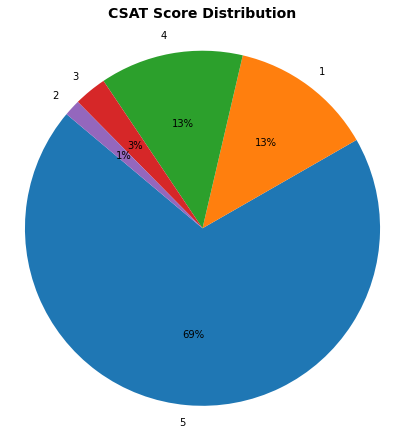

In [16]:
# Pie chart for CSAT score distribution
csat_counts = df['csat_score'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(csat_counts, labels=csat_counts.index, autopct='%1.0f%%', startangle=140)
plt.title('CSAT Score Distribution', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### Chart - 2 CSAT score distibution by category



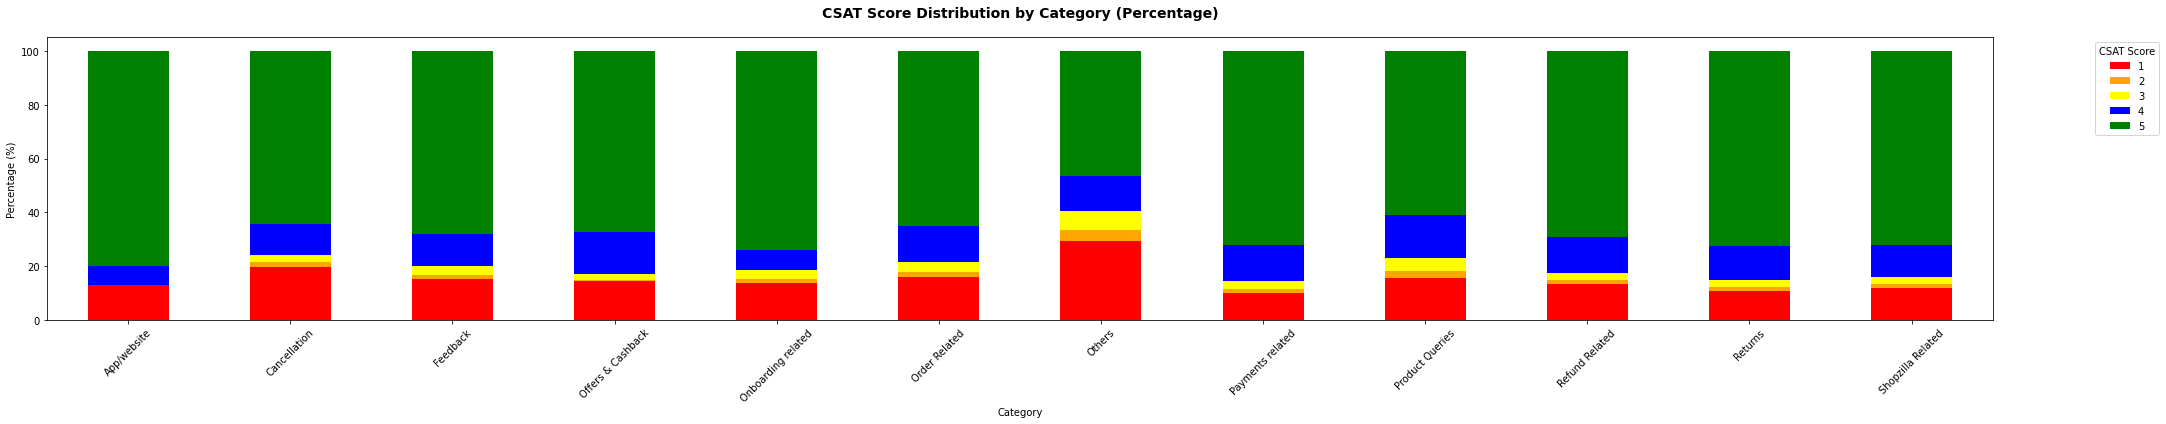

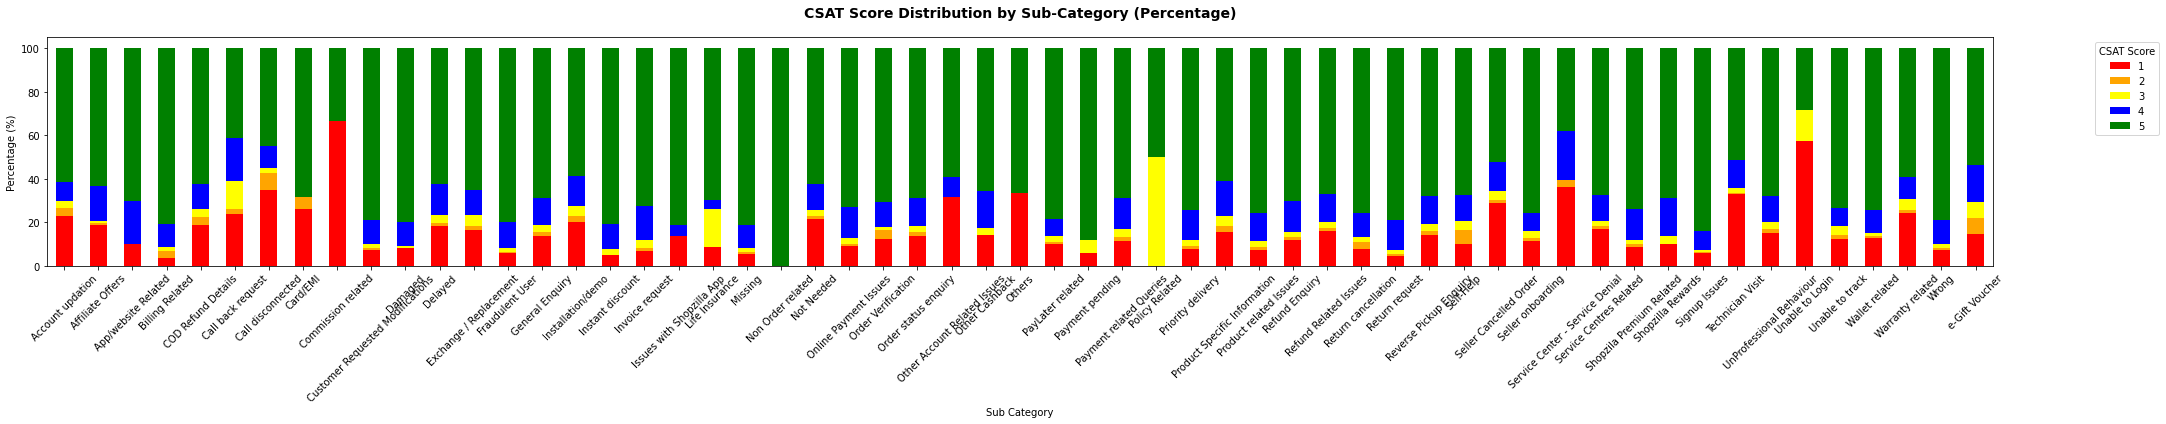

In [17]:
# Calculate percentage of each CSAT score within each category
category_csat_counts = df.groupby(['category', 'csat_score']).size().unstack(fill_value=0)
category_csat_percentages = category_csat_counts.div(category_csat_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
custom_colors = {1: 'red', 5: 'green', 2: 'orange', 3: 'yellow', 4: 'blue'}
# Plot stacked bar chart with custom colors
category_csat_percentages.plot(kind='bar', stacked=True, figsize=(30, 6), color=[custom_colors[col] for col in category_csat_percentages.columns])
# Customize plot labels and legend
plt.title('CSAT Score Distribution by Category (Percentage)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='CSAT Score', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate percentage of each CSAT score within each category
category_csat_counts = df.groupby(['sub-category', 'csat_score']).size().unstack(fill_value=0)
category_csat_percentages = category_csat_counts.div(category_csat_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with custom colors
category_csat_percentages.plot(kind='bar', stacked=True, figsize=(30, 6), color=[custom_colors[col] for col in category_csat_percentages.columns])
# Customize plot labels and legend
plt.title('CSAT Score Distribution by Sub-Category (Percentage)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Sub Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='CSAT Score', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
# Highlight categories where CSAT score 5 > 80%
categories_high_csat1 = category_csat_percentages[category_csat_percentages[5] > 80].index

# Print categories where CSAT score 5 exceeds 80% along with percentages
print(f"Categories where CSAT score 5 exceeds 80%:")
for category in categories_high_csat1:
    percentage = category_csat_percentages.loc[category, 5]
    print(f"- {category}: {percentage:.2f}%")

Categories where CSAT score 5 exceeds 80%:
- Billing Related: 80.70%
- Instant discount: 80.77%
- Issues with Shopzilla App: 81.08%
- Missing: 81.26%
- Non Order related: 100.00%
- Payment pending: 88.24%
- Signup Issues: 84.05%


In [19]:
# Highlight categories where CSAT score 1 > 20%
categories_high_csat1 = category_csat_percentages[category_csat_percentages[1] > 20].index

# Print categories where CSAT score 1 exceeds 20% along with percentages
print(f"Categories where CSAT score 1 exceeds 20%:")
for category in categories_high_csat1:
    percentage = category_csat_percentages.loc[category, 1]
    print(f"- {category}: {percentage:.2f}%")


Categories where CSAT score 1 exceeds 20%:
- Account updation: 22.67%
- Call back request: 23.91%
- Call disconnected: 35.00%
- Card/EMI: 26.32%
- Commission related: 66.67%
- Not Needed: 21.51%
- Other Account Related Issues: 31.82%
- Others: 33.33%
- Seller Cancelled Order: 28.80%
- Service Center - Service Denial: 36.21%
- Technician Visit: 32.80%
- Unable to Login: 57.14%
- Warranty related: 24.36%


#### Chart 3 - CSAT score distribution with customer remarks value presence

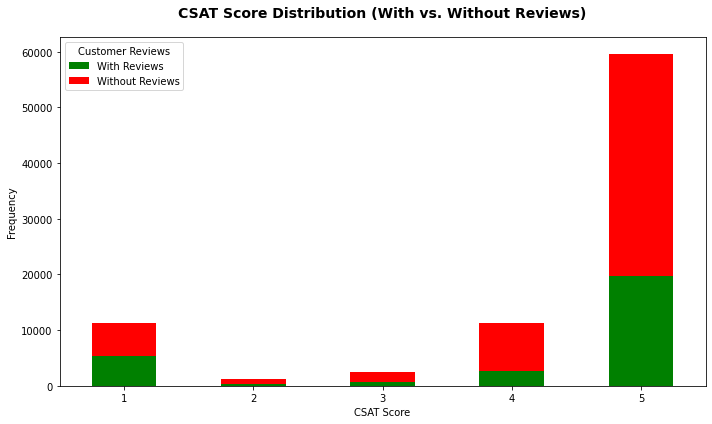

In [20]:
# Check for missing or empty customer reviews
missing_reviews = df['customer_remarks'].isna() | (df['customer_remarks'].str.strip() == '')

# CSAT score distribution by presence of customer reviews
csat_with_reviews = df[~missing_reviews]['csat_score'].value_counts().sort_index()
csat_without_reviews = df[missing_reviews]['csat_score'].value_counts().sort_index()

# Combine the data into a single DataFrame for stacked plotting
csat_combined = pd.DataFrame({
    'With Reviews': csat_with_reviews,
    'Without Reviews': csat_without_reviews
}).fillna(0)

# Plotting the stacked bar chart
csat_combined.plot(kind='bar', stacked=True, color=['green', 'red'], figsize=(10, 6))

# Customize plot labels and title
plt.title('CSAT Score Distribution (With vs. Without Reviews)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('CSAT Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Customer Reviews')

# Display the plot
plt.tight_layout()
plt.show()

In [21]:
# Evidence if the customer are dissatified >50% of them give remarks.
csat_combined

,With Reviews,Without Reviews
csat_score,,
1,5348,5880
2,394,889
3,730,1828
4,2603,8615
5,19667,39944


#### Chart 4 - Sentiment score Distribution and CSAT score distribution with sentiment

In [22]:
# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def calculate_sentiment(remark):
    scores = sid.polarity_scores(remark)
    compound_score = scores['compound']
    return compound_score

# Imputing mode in customer_remarks and with supporting insight from chart-3
df['customer_remarks'] = df['customer_remarks'].fillna('good')
# Apply sentiment calculation
df['sentiment'] = df['customer_remarks'].apply(calculate_sentiment)

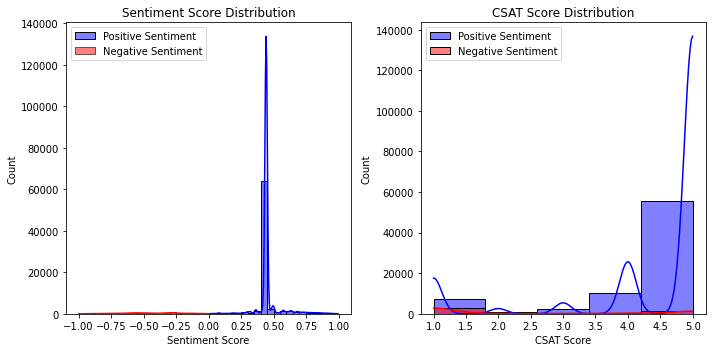

In [23]:
# Set up figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot 1: Sentiment Score Distribution
sns.histplot(df[df['sentiment'] > 0]['sentiment'], bins=20, kde=True, color='blue', ax=axes[0], label='Positive Sentiment')
sns.histplot(df[df['sentiment'] < 0]['sentiment'], bins=20, kde=True, color='red', ax=axes[0], label='Negative Sentiment')
axes[0].set_title('Sentiment Score Distribution')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Count')
axes[0].legend()

# Plot 2: Sentiment Score with CSAT Distribution
# Positive sentiment scores
sns.histplot(df[df['sentiment'] > 0]['csat_score'], bins=5, kde=True, color='blue', alpha=0.5, ax=axes[1], label='Positive Sentiment')
# Negative sentiment scores
sns.histplot(df[df['sentiment'] < 0]['csat_score'], bins=5, kde=True, color='red', alpha=0.5, ax=axes[1], label='Negative Sentiment')
axes[1].set_title('CSAT Score Distribution')
axes[1].set_xlabel('CSAT Score')
axes[1].set_ylabel('Count')
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

#### Chart 5 - Average CSAT Score by Issue Response Date

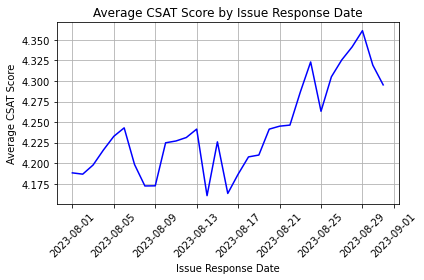

In [24]:
# Aggregate CSAT scores by issue_responded date
csat_by_date = df.groupby(df['issue_responded'].dt.date)['csat_score'].mean()

# Plotting the line chart
plt.figure(figsize=(6, 4))
plt.plot(csat_by_date.index, csat_by_date.values, linestyle='-', color='blue')

plt.title('Average CSAT Score by Issue Response Date')
plt.xlabel('Issue Response Date')
plt.ylabel('Average CSAT Score')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

#### Chart - 6 CSAT score distribution with Manager

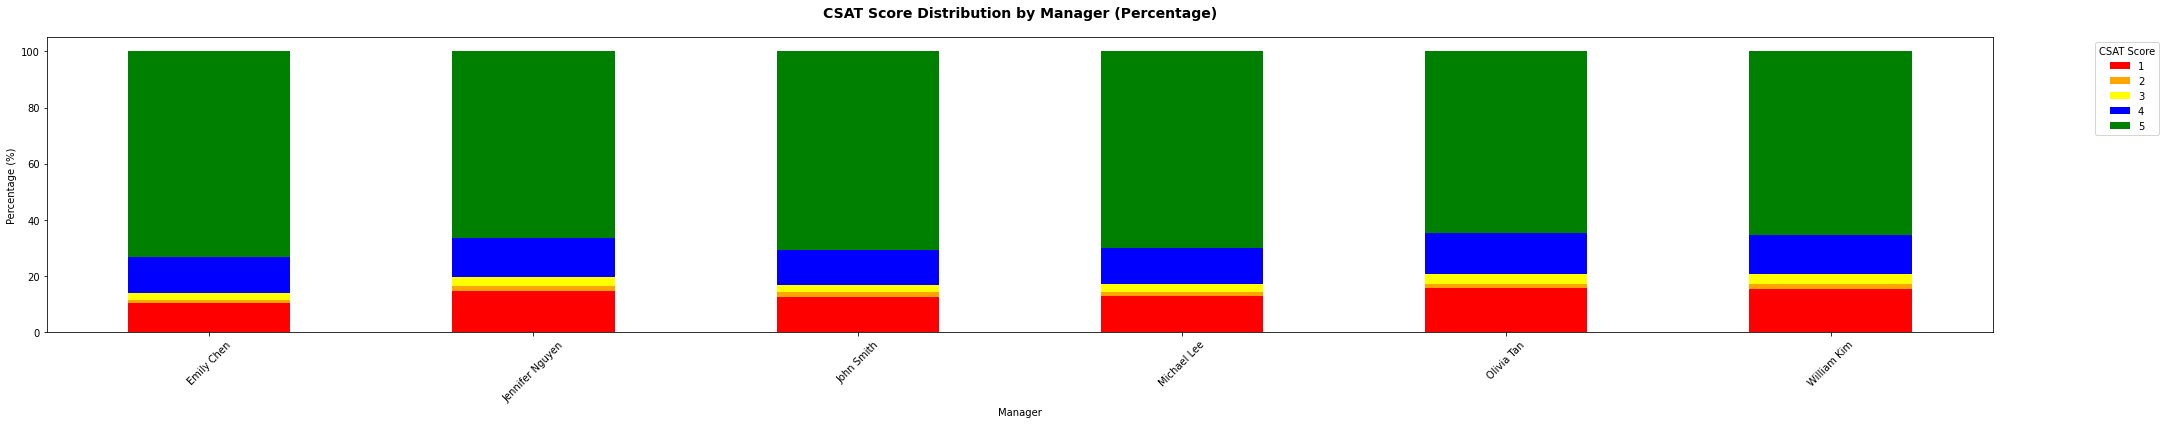

In [25]:
# Calculate percentage of each CSAT score within each category
manager_csat_counts = df.groupby(['manager', 'csat_score']).size().unstack(fill_value=0)
manager_csat_percentages = manager_csat_counts.div(manager_csat_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
custom_colors = {1: 'red', 5: 'green', 2: 'orange', 3: 'yellow', 4: 'blue'}
# Plot stacked bar chart with custom colors
manager_csat_percentages.plot(kind='bar', stacked=True, figsize=(30, 6), color=[custom_colors[col] for col in manager_csat_percentages.columns])
# Customize plot labels and legend
plt.title('CSAT Score Distribution by Manager (Percentage)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Manager')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='CSAT Score', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

#### Chart 7 - Customer Reviews Word Cloud



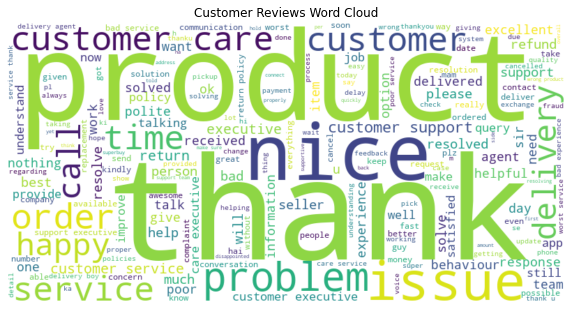

In [26]:
# Combine all customer remarks into a single text string
text = ' '.join(df['customer_remarks'].dropna())

# Remove the word "good" (case insensitive)
text = text.lower().replace('good', '')
text = text.lower().replace('shopzilla', '')


# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Customer Reviews Word Cloud')
plt.axis('off')
plt.show()

#### Chart 8 - Agent performance



In [27]:
# Calculate the average CSAT score for each agent
agent_performance = df.groupby('agent_name')['csat_score'].mean().reset_index()

# Sort the agents by average CSAT score to find top and least performers
top_performers = agent_performance.sort_values(by='csat_score', ascending=False).head()
least_performers = agent_performance.sort_values(by='csat_score', ascending=True).head()

# Display the top performers
print("Top Performers:")
print(top_performers.to_string(index=False))

# Display the least performers
print("\nLeast Performers:")
print(least_performers.to_string(index=False))

Top Performers:
     agent_name  csat_score
Pamela Robinson    4.956522
  Virginia Lane    4.909910
       Sean Gay    4.909091
  Taylor Nelson    4.888889
    Nancy Singh    4.868421

Least Performers:
        agent_name  csat_score
     Philip Harmon    1.809524
    Rebecca Miller    1.954545
   Curtis Mccarthy    2.100000
Virginia Mccormick    2.114286
     Nicole Zavala    2.133333


In [28]:
# Calculate the median CSAT score for each agent
agent_performance = df.groupby('agent_name')['csat_score'].median().reset_index()

# Check which agents have a median CSAT score less than 3
agents_below_3 = agent_performance[agent_performance['csat_score'] < 3]

# Display the agents with a median CSAT score less than 3
print("Agents with a median CSAT score less than 3:")
print(agents_below_3.to_string(index=False))

Agents with a median CSAT score less than 3:
        agent_name  csat_score
      Alyssa Jones         2.0
       Amanda Cook         2.0
       Amber Brown         2.5
   Charles Morales         1.0
  Christine Castro         1.5
   Curtis Mccarthy         1.0
      Jason Wilson         1.5
     Joshua Oliver         2.5
     Melinda Mills         1.0
    Melissa Spence         1.0
     Nicole Zavala         1.0
      Pamela Perez         1.0
     Philip Harmon         1.0
    Rebecca Miller         1.0
      Sarah Keller         1.0
      Tommy Davies         1.0
 Veronica Anderson         1.0
Virginia Mccormick         1.0
      Wesley Meyer         1.0
     Willie Flores         1.0


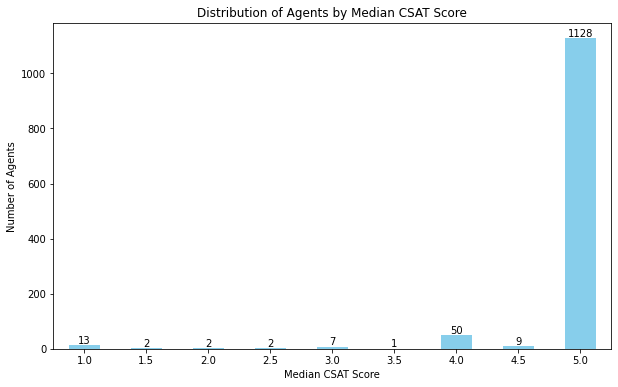

In [60]:
# Assuming 'df' is your DataFrame and 'agent_name' and 'csat_score' are the relevant columns
agent_median_scores = df.groupby('agent_name')['csat_score'].median()

# Count the occurrences of each median score
median_score_counts = agent_median_scores.value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = median_score_counts.plot(kind='bar', color='skyblue')

# Customize the plot
plt.title('Distribution of Agents by Median CSAT Score')
plt.xlabel('Median CSAT Score')
plt.ylabel('Number of Agents')
plt.xticks(rotation=0)  # Rotate x-ticks for better readability

# Add counts above the bars
for index, value in enumerate(median_score_counts):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

### **Overall Insights and Recommendations from EDA**

***EDA INSIGHTS***

**1. CSAT Rating Distribution:**

A significant 70% of customer calls receive a perfect rating of 5, indicating a strong overall satisfaction with customer support. However, 13% of calls are rated at 4, which is still positive but suggests room for improvement. Notably, another 13% of calls are rated as 1, reflecting severe dissatisfaction. To elevate customer support from "Excellent" to "Outstanding," it is crucial to minimize the number of calls receiving a rating of 1. Focused efforts on identifying and addressing the root causes of these low ratings will be essential.

**2. CSAT Score Distribution by Category and Sub-Category:**

Analyzing CSAT scores across different categories and sub-categories reveals that certain areas are prone to lower ratings. Categories like commission-related issues, account-related problems, and call disconnections have a concerning percentage of ratings at 1. In some sub-categories, more than 30% of interactions are rated as 1. On the other hand, sub-categories such as billing & payment, instant discount, non-order related issues, and app-related problems consistently receive ratings of 5, with over 80% of customers expressing high satisfaction. This highlights the need to target specific areas with tailored interventions to reduce dissatisfaction while continuing to reinforce the strengths of high-performing categories.

**3. Customer Remarks and CSAT Scores:**

Customer remarks are provided in about 50% of interactions, predominantly when customers are either highly satisfied or highly disappointed. This pattern suggests that remarks are a strong indicator of customer sentiment. Given that 'good' is the most common remark, it is recommended to impute 'good' in cases where no remark is provided. This approach will maintain data consistency and align with the observed mode in customer feedback.

**4. Trend in CSAT Scores:**

There is an observable upward trend in CSAT scores, indicating an overall improvement in customer satisfaction over time. This positive trajectory should be monitored closely, and efforts should continue to maintain and accelerate this growth, particularly by addressing areas of persistent dissatisfaction.

**5. Manager Performance:**

The analysis shows that all managers maintain a similar level of CSAT scores, suggesting a consistent performance across leadership. While this consistency is positive, it also indicates that there may be opportunities for innovation and differentiation in management practices to further enhance customer satisfaction.

**6. Focus on Low-Performing Agents:**

There are 20 agents with a median CSAT score of less than 3. This group represents a critical area for improvement. Implementing targeted training programs and conducting detailed performance reviews could help these agents address specific challenges and elevate their performance. Addressing the issues faced by these agents will be key to improving overall customer satisfaction.

**Recommendations:**
1. Targeted Interventions: Focus on the categories and sub-categories with high percentages of low ratings (1s) to identify and resolve underlying issues.
2. Training and Development: Provide additional support and training to the 20 agents with a median CSAT score of less than 3 to improve their performance.
3. Proactive Customer Engagement: Leverage the upward trend in CSAT scores to explore new ways of exceeding customer expectations, especially in high-performing areas like billing and app-related issues.
4. Continuous Monitoring: Maintain a consistent review of CSAT scores across categories, sub-categories, and agents to ensure that improvements are sustained and areas of dissatisfaction are promptly addressed.

## ***4. Data Transformation***

### 1. Feature Engineering

In [29]:
# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def calculate_sentiment(remark):
    scores = sid.polarity_scores(remark)
    compound_score = scores['compound']
    return compound_score

# Imputing mode in customer_remarks
df['customer_remarks'] = df['customer_remarks'].fillna('Neutral')
# Apply sentiment calculation
df['sentiment'] = df['customer_remarks'].apply(calculate_sentiment)

In [30]:
# Creating features based on issue_responded, issue_reported_at and survey_response_date
df['wait_response_time'] = (df['issue_responded'] - df['issue_reported_at']).dt.total_seconds()/60

# Note : survey_response date and issue_responded on same date for all rows.

# Calculate mean of Wait_response_time where it's greater than 0
mean_wait_response_time = df[df['wait_response_time'] > 0]['wait_response_time'].mean()
# Impute negative values with mean
df['wait_response_time'] = df['wait_response_time'].apply(lambda x: mean_wait_response_time if x < 0 else x)

### 2. Drop Unnecesary columns

In [31]:
# Drop unnecessary columns and columns with very high percentage of nulls
# Drop columns which are not useful because of high number of missing values or high number of categories
drop_cols = ['order_date_time', 'customer_city',	'product_category',
           'item_price',	'connected_handling_time', 'customer_remarks', 'issue_reported_at',	'issue_responded',
             'survey_response_date']
df = df.drop(columns=drop_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85898 entries, 0 to 85906
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   channel_name        85898 non-null  object 
 1   category            85898 non-null  object 
 2   sub-category        85898 non-null  object 
 3   agent_name          85898 non-null  object 
 4   supervisor          85898 non-null  object 
 5   manager             85898 non-null  object 
 6   tenure_bucket       85898 non-null  object 
 7   agent_shift         85898 non-null  object 
 8   csat_score          85898 non-null  int64  
 9   sentiment           85898 non-null  float64
 10  wait_response_time  85898 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 7.9+ MB


In [32]:
# Lets see if we have any duplicate rows
df = check_drop_duplications(df)

Count of duplicate rows : 4668
Dropping duplicates


Columns with high null% and unuseful columns for the csat score prediction are dropped.

### 3. Encoding

In [33]:
# Create directory for pickle files if it doesn't exist
pkl_folder = 'pkl_files'
os.makedirs(pkl_folder, exist_ok=True)

In [34]:
#Reset index
df.reset_index(inplace = True, drop=True)

# Columns for one-hot encoding
columns_for_one_hot_encoding = ['channel_name', 'category', 'tenure_bucket', 'agent_shift']

# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False, drop='first', dtype=int)

# Fit and transform the data
one_hot_encoded = one_hot_encoder.fit_transform(df[columns_for_one_hot_encoding])

# Convert the result into a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(columns_for_one_hot_encoding))

# Combine the one-hot encoded columns with the original DataFrame (excluding the original categorical columns)
df = pd.concat([df.drop(columns=columns_for_one_hot_encoding), one_hot_encoded_df], axis=1)

# Save the one-hot encoder to a pickle file
one_hot_encoder_path = os.path.join(pkl_folder, 'one_hot_encoder.pkl')
with open(one_hot_encoder_path, 'wb') as f:
    pickle.dump(one_hot_encoder, f)

In [35]:
# Assuming the DataFrame is already loaded as 'df'
# Ensure there are no NaN values initially
assert df[['sub-category', 'agent_name', 'supervisor', 'manager']].isna().sum().sum() == 0, "There are NaN values initially!"

# Columns for target encoding
columns_for_target_encoding = ['sub-category', 'agent_name', 'supervisor', 'manager']

# Perform target encoding
target_encoders = {}
for col in columns_for_target_encoding:
    scaler = TargetEncoder()
    df[col] = scaler.fit_transform(X=df[col], y=df['csat_score'])
    target_encoders[col] = scaler

# Check if any NaN values appeared after encoding
if df[columns_for_target_encoding].isna().sum().sum() > 0:
    print("Warning: NaN values found after target encoding. Consider imputing or handling them.")
else:
    print("Target encoding applied successfully without introducing NaN values.")



Target encoding applied successfully without introducing NaN values.


#### Data Encoding Overview

For the preprocessing of categorical variables in our dataset, we employed two types of encoding techniques:

1. **One-Hot Encoding:**
   - Applied to the columns: `channel_name`, `category`, `tenure_bucket`, and `agent_shift`.
   - The one-hot encoded features were stored using `OneHotEncoder` from `sklearn` and saved in a pickle file named `one_hot_encoder.pkl`.

2. **Target Encoding:**
   - Applied to the columns: `sub-category`, `agent_name`, `supervisor`, and `manager`.
   - The target encoders were created using `TargetEncoder` from the `category_encoders` library and saved in a pickle file named `target_encoders.pkl`.

These pickle files ensure that the same encodings can be consistently applied to future datasets, such as test data, maintaining consistency and accuracy across the model pipeline.


### 4. Data Transformation

In [36]:
# Separate features and target
X = df.drop(columns=['csat_score'])
y = df['csat_score'].values.reshape(-1, 1)  # Reshape y to a 2D array

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler for both X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Save the scalers for future use
with open('pkl_files/scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
    
with open('pkl_files/scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

# Convert the scaled data back to DataFrame if needed
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train_scaled = pd.DataFrame(y_train_scaled, columns=['csat_score'])

#### Scaling the Training Data

To ensure consistent feature scaling across the dataset, we applied the `MinMaxScaler` from `sklearn.preprocessing`. The scaling process involves the following steps:

1. **Fitting the Scaler on Training Data:**
   - The `MinMaxScaler` was fitted on the complete data. This process calculates the minimum and maximum values for each feature dataset.
   - These values are used to scale the features within a range of [0, 1], ensuring that each feature contributes proportionally to the model.

2. **Transforming the Training Data:**
   - After fitting, the scaler was used to transform the data, applying the calculated scaling parameters (min and max values) to each feature. This transformation normalizes the data, which helps in improving the convergence of gradient-based optimization algorithms used in many machine learning models.

3. **Saving the Scaler:**
   - The fitted scaler was saved to a pickle file (`min_max_scaler.pkl`). This ensures that the same scaling parameters can be consistently applied to the test data and any future datasets, maintaining the integrity of the model's performance.

By following this approach, we ensure that the model is trained on appropriately scaled data, while preventing any data leakage from the test set.


## ***5.Modelling & Evaluation***

In [37]:
# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)

# Assuming X_train and X_val are your feature matrices
input_dim = X_train.shape[1]

#### Neural Network Architecture Overview

The neural network model is designed to predict CSAT (Customer Satisfaction) scores using a simple yet effective architecture. The key components of this model are as follows:

1. **Input Layer:**
   - The model begins with an input layer that accepts features from the dataset. The number of input neurons corresponds to the number of features in the input data (`input_dim`).

2. **First Hidden Layer:**
   - A dense (fully connected) layer with 64 neurons is used, employing the ReLU (Rectified Linear Unit) activation function. This layer captures non-linear relationships within the data.
   - A dropout layer follows this dense layer, with a dropout rate of 20% (`0.2`). This technique helps prevent overfitting by randomly setting 20% of the layer's output to zero during training.

3. **Second Hidden Layer:**
   - Another dense layer with 64 neurons, again using the ReLU activation function. This additional layer allows the model to learn more complex patterns from the data.
   - This is followed by another dropout layer, also with a dropout rate of 20%.

4. **Output Layer:**
   - The output layer consists of a single neuron with a linear activation function. This is suitable for regression tasks, such as predicting a continuous value like the CSAT score.

5. **Compilation:**
   - The model is compiled using the Adam optimizer, with a learning rate of `0.001`. Adam is an adaptive learning rate optimization algorithm that combines the best properties of the AdaGrad and RMSProp algorithms, making it well-suited for this task.
   - The loss function is `mean_squared_error`, which is appropriate for regression problems, as it measures the average squared difference between the predicted and actual values.
   - The model's performance is tracked using the `accuracy` metric, although for regression, this may represent a custom or adjusted interpretation of accuracy.

6. **Early Stopping:**
   - To prevent overfitting and ensure that the model retains the best weights during training, early stopping is employed. The training process is monitored on the validation loss, and if no improvement is seen for 5 consecutive epochs, training is stopped, and the best model weights are restored.

This architecture balances simplicity and power, making it suitable for predicting CSAT scores while incorporating regularization techniques to avoid overfitting.


### Model - 1

In [38]:
# Model Architecture
# Input layer > Dropout > Hidden layer with relu activation > Dropout > Output layer
# Defined parameters -> neurons = 64, dropout rate = 0.2, learning rate = 0.001

def create_model(neurons=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(input_dim,), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['accuracy'])
    return model

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [39]:
# Create the model with defined parameters
model_v0 = create_model()

# Train the model
history_v0 = model_v0.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model_v0.evaluate(X_val, y_val)
print(f'Mean Absolute Error: {accuracy}')
print(f'Mean Squared Error: {loss}')

Epoch 1/100
1625/1625 [==============================] - 5s 3ms/step - loss: 0.1229 - accuracy: 0.6803 - val_loss: 0.1040 - val_accuracy: 0.6982
Epoch 2/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1072 - accuracy: 0.6993 - val_loss: 0.0979 - val_accuracy: 0.7000
Epoch 3/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1036 - accuracy: 0.7019 - val_loss: 0.0982 - val_accuracy: 0.6998
Epoch 4/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1021 - accuracy: 0.7025 - val_loss: 0.0971 - val_accuracy: 0.7001
Epoch 5/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1011 - accuracy: 0.7020 - val_loss: 0.0971 - val_accuracy: 0.7007
Epoch 6/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1006 - accuracy: 0.7032 - val_loss: 0.0976 - val_accuracy: 0.7014
Epoch 7/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1000 - accuracy: 0.7037 - val_loss: 0.0972 - val_ac

In [40]:
model_v0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________


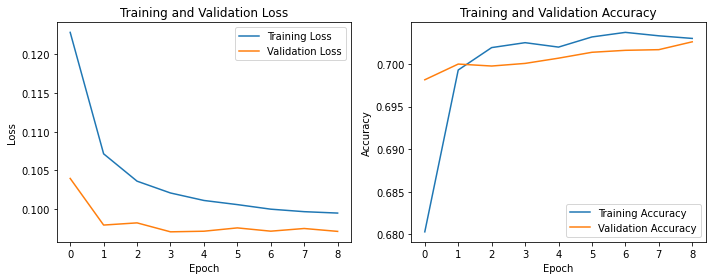

In [41]:
# Plotting loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_v0.history['loss'], label='Training Loss')
plt.plot(history_v0.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history_v0.history['accuracy'], label='Training Accuracy')
plt.plot(history_v0.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# Save the best model in HDF5 format (common format for Keras models)
model_v0.save('models_saved/model_v0.h5')

### Model 2 - Decaying learning rate

In [43]:

def create_model_v1(neurons=64, dropout_rate=0.2, initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.96):
    input_dim = X_train.shape[1]  # Assuming X_train is your training data
    
    # Adjusted learning rate schedule with slower decay
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=False
    )
    
    model = Sequential()
    model.add(Dense(neurons, input_shape=(input_dim,), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mean_squared_error', metrics=['accuracy'])
    return model

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [44]:
# Create the model with defined parameters
model_v1 = create_model_v1()

# Train the model
history_v1 = model_v1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model_v1.evaluate(X_val, y_val)
print(f'Mean Absolute Error: {accuracy}')
print(f'Mean Squared Error: {loss}')

Epoch 1/100
1625/1625 [==============================] - 5s 3ms/step - loss: 0.1138 - accuracy: 0.6875 - val_loss: 0.1008 - val_accuracy: 0.6985
Epoch 2/100
1625/1625 [==============================] - 4s 3ms/step - loss: 0.1055 - accuracy: 0.6975 - val_loss: 0.1002 - val_accuracy: 0.6996
Epoch 3/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1050 - accuracy: 0.6967 - val_loss: 0.0994 - val_accuracy: 0.6982
Epoch 4/100
1625/1625 [==============================] - 6s 4ms/step - loss: 0.1039 - accuracy: 0.6973 - val_loss: 0.0991 - val_accuracy: 0.6997
Epoch 5/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1037 - accuracy: 0.6993 - val_loss: 0.1020 - val_accuracy: 0.7008
Epoch 6/100
1625/1625 [==============================] - 4s 2ms/step - loss: 0.1029 - accuracy: 0.6996 - val_loss: 0.0976 - val_accuracy: 0.7018
Epoch 7/100
1625/1625 [==============================] - 6s 4ms/step - loss: 0.1022 - accuracy: 0.7006 - val_loss: 0.1041 - val_ac

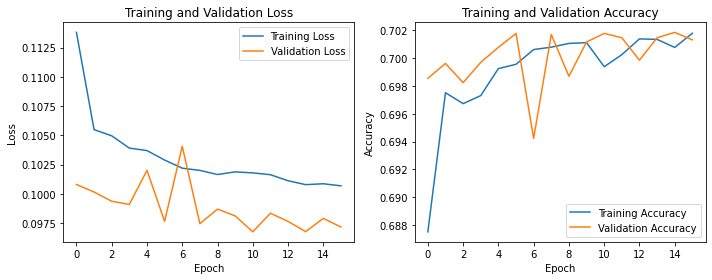

In [45]:
# Plotting loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_v1.history['loss'], label='Training Loss')
plt.plot(history_v1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history_v1.history['accuracy'], label='Training Accuracy')
plt.plot(history_v1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Decaying Learning Rate Benefits

A decaying learning rate gradually reduces the step size during training, allowing the model to make finer adjustments as it converges. This often leads to faster convergence by reducing the number of epochs needed without sacrificing accuracy. In this case, applying a decaying learning rate helped decrease the total training time by lowering the number of epochs, while maintaining the same level of accuracy.


In [46]:
# Save the best model in HDF5 format (common format for Keras models)
model_v1.save('models_saved/model_v1.h5')

### Model 3 - Hyperparameter tuning

In [48]:
# Custom callback to log iterations and epochs
class PrintEpochCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch: {epoch}")

# Custom callback to store history
class StoreHistoryCallback(Callback):
    def on_train_begin(self, logs=None):
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

# Instantiate the callbacks
print_epoch_callback = PrintEpochCallback()
store_history_callback = StoreHistoryCallback()

In [49]:
# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the random search parameters with scaled uniform distributions
param_dist = {
    'neurons': randint(32, 129),  # Random integers between 32 and 128 inclusive
    'dropout_rate': uniform(0.1, 0.4),  # Uniform distribution from 0.1 to 0.5
    'batch_size': randint(16, 65),  # Random integers between 16 and 64 inclusive
    'epochs': randint(50, 151),  # Random integers between 50 and 150 inclusive
    'learning_rate': uniform(0.001, 0.009)  # Uniform distribution from 0.001 to 0.01
}

# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=4, cv=5, verbose=2, n_jobs=-1)

# Fit the model with random search
random_search_result = random_search.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping, print_epoch_callback,  store_history_callback])

# Print the best parameters and best score
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Restoring model weights from the end of the best epoch: 6.
Epoch: 10
Epoch 11: early stopping
Best: -0.098842 using {'batch_size': 17, 'dropout_rate': 0.10358624901434821, 'epochs': 110, 'learning_rate': 0.006884380071209129, 'neurons': 107}


#### Model Overview and Hyperparameter Tuning

This model is a neural network designed for regression tasks, specifically to predict continuous target values. The architecture consists of two hidden layers, each with ReLU activation and dropout for regularization. The output layer uses a linear activation function, suitable for regression. The model is compiled with the Adam optimizer and mean squared error as the loss function.

**Hyperparameter Tuning:**
- A `RandomizedSearchCV` approach is used to optimize key hyperparameters, including the number of neurons, dropout rate, batch size, epochs, and learning rate.
- Custom callbacks are employed to log training progress (`PrintEpochCallback`) and store training history (`StoreHistoryCallback`).
- Validation data and callbacks are passed during the training process to ensure robust evaluation and to prevent overfitting with early stopping.


In [50]:
# Extract the best model
best_model = random_search_result.best_estimator_.model

# Evaluate the model to get the custom accuracy
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Print the model summary
best_model.summary()

407/407 [==============================] - 1s 1ms/step - loss: 0.0977 - accuracy: 0.7014
Loss: 0.09773694723844528
Accuracy: 0.701392650604248
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 107)               2996      
                                                                 
 dropout_4 (Dropout)         (None, 107)               0         
                                                                 
 dense_7 (Dense)             (None, 107)               11556     
                                                                 
 dropout_5 (Dropout)         (None, 107)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 108       
                                                                 
Total params: 14,660
Trainable params: 14,6

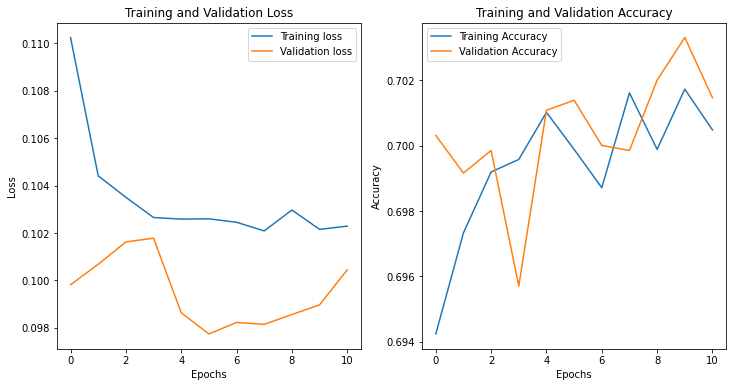

In [51]:
# Plotting the training history
history_dict = store_history_callback.history

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training loss')
plt.plot(history_dict['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot the training and validation custom accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [52]:
# Save the best model in HDF5 format (common format for Keras models)
best_model.save('models_saved/best_model.h5')

## ***6.Predictions***

### Tranform test data and Evaluation

In [53]:
# # Transform the test data using the same scaler
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)

In [54]:
# Evaluate the model to get the accuracy
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

508/508 [==============================] - 1s 1ms/step - loss: 0.1009 - accuracy: 0.7071
Loss: 0.10086913406848907
Accuracy: 0.7071279287338257


### Visulaization actuals vs predictions

In [55]:
# Generate predictions for the validation set
y_pred = best_model.predict(X_test)

508/508 [==============================] - 1s 1ms/step


In [56]:
min_y = 1  # Replace with your original min value of y
max_y = 5  # Replace with your original max value of y

# Reverse scaling using the formula
y_test_real = y_test * (max_y - min_y) + min_y
y_pred_real = (y_pred * (max_y - min_y) + min_y).round()

# Compare predictions to actual values
comparison_df = pd.DataFrame({'Actual': y_test_real.flatten(), 'Predicted': y_pred_real.flatten()})
comparison_df['Difference'] = comparison_df['Actual'] - comparison_df['Predicted']
comparison_df.head()

,Actual,Predicted,Difference
0,5.0,4.0,1.0
1,5.0,5.0,0.0
2,1.0,2.0,-1.0
3,5.0,4.0,1.0
4,5.0,5.0,0.0


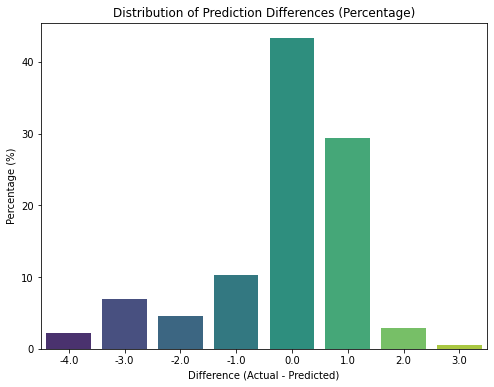

In [57]:
# Calculate the percentage of each difference value
difference_percentage = comparison_df['Difference'].value_counts(normalize=True) * 100

# Convert to DataFrame for easier plotting
difference_percentage_df = difference_percentage.reset_index()
difference_percentage_df.columns = ['Difference', 'Percentage']

# Sort the differences for better plotting
difference_percentage_df = difference_percentage_df.sort_values('Difference')

# Plot the distribution of differences in percentages
plt.figure(figsize=(8, 6))
sns.barplot(x='Difference', y='Percentage', data=difference_percentage_df, palette='viridis')

plt.xlabel('Difference (Actual - Predicted)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Prediction Differences (Percentage)')
plt.show()

This plot will visually represent how frequently the model’s predictions differ from the actual values by specific amounts, expressed as a percentage of the total predictions. This is helpful to understand the model's accuracy and error distribution.

## ***7.Conclusion*** 

The development of the CSAT prediction model involved several critical steps, including data preparation, feature engineering, and model development. The model was designed to predict customer satisfaction scores based on key factors such as response times, sentiment analysis, and customer interactions. By accurately forecasting these scores, the model provides valuable insights into customer behavior and areas where service improvements can be made.

The model has successfully identified key drivers of customer satisfaction and demonstrated its potential to predict CSAT scores with a high degree of accuracy. The analysis revealed that factors like response times and the sentiment of customer reviews play a significant role in determining satisfaction levels. While the model performs well overall, some discrepancies between predicted and actual scores highlight opportunities for further refinement.

### Action Points

1. **Optimize Customer Service Operations:**

   - **Reduce Response Times:** Implement strategies to minimize customer wait times, as this has been shown to significantly impact satisfaction. Consider increasing staff during peak periods or leveraging automation to improve response efficiency.

   - **Monitor and Improve Customer Sentiment:** Use the insights from sentiment analysis to proactively address negative feedback and reinforce positive experiences. This could involve targeted training for customer service representatives or adjusting service protocols.

2. **Enhance Data Quality and Model Accuracy:**

   - **Refine Feature Engineering:** Continuously improve the model by exploring additional features that may contribute to more accurate predictions. Regularly update the dataset to reflect the most recent customer interactions and trends.

   - **Address Prediction Outliers:** Investigate cases where the model's predictions deviate significantly from actual scores to identify potential service gaps or areas for process improvement.

3. **Deploy Model for Proactive Customer Management:**

   - **Real-Time Monitoring:** Integrate the model into customer service operations to provide real-time predictions that can guide decision-making and improve customer satisfaction proactively.
   
   - **Strategic Use of Insights:** Leverage the model’s predictions to inform broader business strategies, such as resource allocation, training programs, and service enhancements, to drive continuous improvement in customer satisfaction.
